In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

## Steps:

1) open sound file

2) fft

3) identify top peaks (all peaks above threshold)

TODO:

4) convert peaks to notes NOTE: guitar must be tuned

Using this table of note frequencies: https://www.liutaiomottola.com/formulae/freqtab.htm

5) put notes in a set (no repeats)

6) send set of notes to website for identification

## Ideas:

- can the sound be read straight into an array rather than saving as wav and then reading it?
- trim silence from audio file (only start reording once the volume is above threshold (this is website side, not in this code)
- trim frequency spectrum to within range of guitar frequencies (does this improve speed? The frequencies outside this range are probably not going to have high enough amplitudes to matter anyways))
- remove frequencies from table if they are too high/low for a guitar to play


# parameters:
- threshold for a frequency to count as a "main frequency", currently set to max_amplitude/5

In [2]:
# GLOBAL VARIABLES (TABLE OF NOTE FREQUENCIES)

# read, rewrite, and save table of not frequencies
import pandas as pd

noteTable = np.genfromtxt('note_frequency_table.csv', delimiter=',', encoding="utf-8-sig", dtype=None, invalid_raise = False, comments=None)
noteNames = np.array(noteTable[1:, 0])
noteFreqs = np.array(noteTable[1:, 1]).astype(float)
print(noteNames)


# create pandas dataframe (unnecessary)
noteTable = pd.DataFrame(noteTable[1:, :], columns=noteTable[0])
noteTable

['C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#'
 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G'
 'G#' 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B'
 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#'
 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G'
 'G#' 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B'
 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#'
 'E' 'F' 'F#' 'G' 'G#' 'A' 'A#' 'B']


,Note Name,Frequency (Hz)
0,C,16.351
1,C#,17.324
2,D,18.354
3,D#,19.445
4,E,20.601
...,...,...
115,G,12543.856
116,G#,13289.752
117,A,14080
118,A#,14917.24


In [3]:
def freqToNote(freq):
    '''
    Given a frequency return the name of the note that is closest to the frequency provided, using this table of 
    frequencies of musical notes:
    
    https://www.liutaiomottola.com/formulae/freqtab.htm
    '''
    
    # mean ratio between consecutive notes (technically all are equal, but we only have up to 3 decimals in table so ratios aren't exact)
    ratio = 1.0594634189848198
    
    # first note in the table:
    firstNote = 16.351
    
    # approximate index (rounded down) of freq in the table
    i = np.log(freq/firstNote)/np.log(ratio)
    #print("i:", i)
    #print("i:", i.astype(int))
    # the frequency correspondds to the note at index i or i+1 in the table, so check which is closest
    #print(freq, " is either", noteNames[int(i)], " or ", noteNames[int(i)+1])
    #print(freq, " is either", noteFreqs[int(i)], " or ", noteFreqs[int(i)+1])

    # TODO: max of i and i+1, in a way that allows vectorization (get 2 2-element arrays (names and freqs) return index of max of the subtraction)
    freqDifference = np.array([np.abs(freq - noteFreqs[i.astype(int)]), np.abs(freq - noteFreqs[i.astype(int)+1])])
    
    possibleNotes = np.array([noteNames[i.astype(int)], noteNames[i.astype(int)+1]]).T
    
    #print("frequency difference: \n", freqDifference)
    #print("shape:", freqDifference.shape)
    
    #print("possible notes:\n", possibleNotes)
    #print("shape:", possibleNotes.shape)
    
    #print("argmin:\n", np.argmin(freqDifference, axis=0))
    
    indices = (np.arange(freqDifference.shape[1]), np.argmin(freqDifference, axis=0))
    #print("indices:\n", indices)
    

    note = possibleNotes[indices]
        
    return note
    

def getSignal(fileName, drawPlots=False):
    '''
    Read the given .wav file and return the signal
    '''
    # Read the .wav file to get the sampling rate and the data contained in the file
    sampFreq, sound = wavfile.read(fileName)

    #    sound.dtype = 'int16'means that the sound pressure values are mapped to integer values that can range from -2^15 to (2^15)-1. The samples are taken 44100 times per second.
    
    #    We can convert our sound (numpy) array to floating point values ranging from -1 to 1 as follows:
    #sound = sound / 2.0**15 


    # Duration of the chord/sound (in seconds):
    duration = sound.shape[0] / sampFreq


    # To get the proper time on the x-axis we have to generate a numpy array using sampFreq:
    time = np.arange(sound.shape[0]) / sound.shape[0] * duration

    # select a single channel:
    signal = sound[:,0] 
    
    
    if drawPlots:
        plt.plot(time, signal)
        plt.xlabel("Time(s)")
        plt.ylabel("Amplitude")
        plt.title("Signal")
        plt.show()
    
    
    return signal, sampFreq







In [32]:
def Identify(fileName, thresh=3, drawPlots=False):
    '''
    Identifies the chord in the file with name fileName using Fourier analysis.
    
    Returns the chord (list of the notes in the major triad), the root note, and the duration the chord 
    plays for (ie. length of the wav file) in seconds
    '''

    signal, sampFreq = getSignal(fileName, drawPlots)

    s=time.time()
    
    # Find the amplitude of each frequency using fast fourier transform
    fft_spectrum = np.fft.rfft(signal)
    amp = np.abs(fft_spectrum)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    print("FFT time:", time.time()-s)
    
    threshold = np.max(amp)/thresh
    
    
    # amplitudes that are above the threshold
    main_amp = np.where(amp>threshold, amp, 0)  # similar to amp, but amplitudes of all frequencies that are below the threshold are set to zero
    main_freqs = freq[np.argwhere(amp>threshold)][:, 0]  
    
    #mainAmp is for plotting purposes only, we really only care about the argwhere
    
    
    # Plot the frequencies   
    if drawPlots:
        f1 = plt.figure()
        plt.plot(freq[:4500], amp[:4500])
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.title("Frequency spectrum")
        plt.plot(np.arange(1200), np.ones(1200)*threshold, label="threshold")
        plt.legend(loc="upper right")
        for i, note in enumerate(freqToNote(freq[np.argwhere(amp>threshold/2)][:, 0][:])):
            plt.annotate(note, (freq[np.argwhere(amp>threshold/2)][:, 0][i], amp[np.argwhere(amp>threshold/2)][:, 0][i]))
        plt.show()
    
    
    # convert frequencies above threshold to notes
    all_chord_notes = freqToNote(main_freqs[:])
    chord_notes = set(all_chord_notes)
    
    
    if drawPlots:
        f1 = plt.figure()
        plt.plot(freq[:3500], main_amp[:3500])
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.title("Main frequencies in spectrum")
        for i, note in enumerate(all_chord_notes):
            plt.annotate(note, (main_freqs[i], main_amp[np.argwhere(amp>threshold)][:, 0][i]))
        plt.show()

    return chord_notes, main_freqs, all_chord_notes


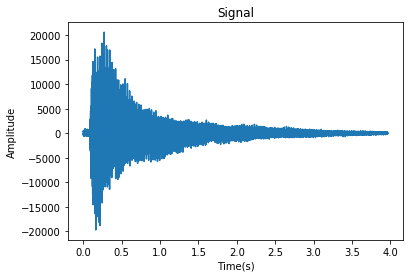

FFT time: 0.011989355087280273


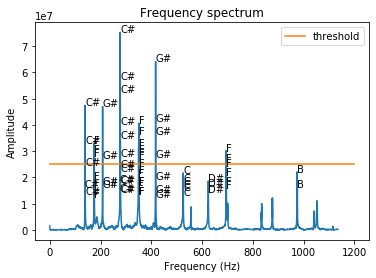

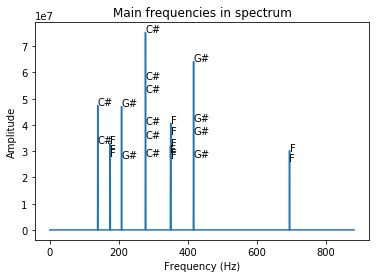

Run time: 0.8135409355163574


In [33]:
import time
s=time.time()
chord_notes, main_freqs, all_chord_notes = Identify('C#.wav', thresh=3, drawPlots=True)
print("Run time:", time.time()-s)

In [34]:
print(main_freqs)
print(all_chord_notes)
print(chord_notes)

[138.69431213 138.94648361 174.75483329 175.00700476 175.25917624
 207.78929672 208.0414682  276.88428131 277.13645279 277.38862426
 277.64079574 277.89296722 278.14513869 349.76183805 350.01400953
 350.266181   350.51835248 350.77052396 351.02269543 416.33510787
 416.58727935 416.83945083 417.0916223  694.73241804 694.98458952]
['C#' 'C#' 'F' 'F' 'F' 'G#' 'G#' 'C#' 'C#' 'C#' 'C#' 'C#' 'C#' 'F' 'F' 'F'
 'F' 'F' 'F' 'G#' 'G#' 'G#' 'G#' 'F' 'F']
{'C#', 'F', 'G#'}
